# Copy States Optimization

This notebook demonstrates how to parse and visualize the results produced by the ParticleDA.jl script  
[`extra/weak_scaling/kathleen_slurm_copy_states.sh`](extra/weak_scaling/kathleen_slurm_copy_states.sh).

It provides a practical example of how to process the benchmarking output generated on the Kathleen cluster,  
summarize weak scaling performance metrics, and reproduce the plots presented in the accompanying report.

The notebook serves as a reference for interpreting the performance impact of the new `copy_states!`  
optimisation and offers a reproducible workflow for future benchmarking experiments.

Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

#### Import necessary packages and define helper functions

In [83]:
using HDF5
using Serialization
using DataFrames, Plots, Statistics
using Plots.PlotMeasures 
using DataFramesMeta
using Missings
using ColorSchemes

has_data(v) = any(!ismissing, v)
safe_mean(v) = has_data(v) ? mean(skipmissing(v)) : missing
safe_std(v) = has_data(v) ? std(collect(skipmissing(v)); corrected=false) : missing
safe_min(v)  = has_data(v) ? minimum(skipmissing(v)) : missing
safe_max(v)  = has_data(v) ? maximum(skipmissing(v)) : missing


# The following functions rename the plot labels for better readability
# e.g., rename_regime("1(1.0) particles") returns "Extreme degeneracy"
# If no match is found, the original string is returned
function rename_regime(trial)
    if trial == "1(1.0) particles"
        return "Extreme degeneracy"
    elseif trial == "1(0.999) particles"
        return "High degeneracy"
    elseif trial == "1(0.99) particles"
        return "Near-degeneracy(0.99)"
    elseif trial == "50%(1.0) particles"
        return "Balanced case"
    elseif trial == "all(1.0) particles"
        return "Uniform case"
    end
    return trial
end

function rename_stats(metric)
    if metric == "waitall_ratio"
        return "Waitall/Overall Time Ratio"
    elseif metric == "overall"
        return "Overall Time (s)"
    elseif metric == "copy_states"
        return "Copy States Time (s)"
    elseif metric == "waitall_phase"
        return "Waitall Time (s)"
    elseif metric == "optimize_resample"
        return "Optimise Resample (s)"
    elseif metric == "resample_ratio"
        return "Overhead Time Ratio"
    end
    return metric
end

function rename_optimization(optimization)
    if optimization == "original"
        return "Baseline"
    elseif optimization == "only_optimize_resampling"
        return "Optimise Resampling Only"
    elseif optimization == "only_dedup"
        return "Deduplication Only"
    elseif optimization == "dedup_threading"
        return "Deduplication + Threading"
    elseif optimization == "dedup_threading_optimize_resampling"
        return "Full Optimisation"
    end
    return optimization
end

rename_optimization (generic function with 1 method)

#### Functions to parse output

In [84]:

function timer_dict_to_df(timer_dict, optimization, flatten=false)
    rows = []

    for (trial, ranks) in timer_dict
        # parse the original trial string in the format "k:total_rank:nprt_per_rank:n_float_per_particle:perm:p"
        k, total_rank, nprt_per_rank, n_float_per_particle, perm, p = split(trial, ":")
        k = k == "half" ? "50%" : k
        trial_name = "$k($p) particles"
        for (rank, timers) in ranks
            function format_row(op, metric, value)
                return (
                    optimization = optimization,
                    trial  = String(trial_name),
                    perm = String(perm),
                    total_rank = parse(Int, total_rank),
                    particle_size = n_float_per_particle,
                    nprt_per_rank = nprt_per_rank,
                    rank   = string(rank),
                    op     = String(op),
                    metric = String(metric),
                    value  = value,
                )
            end
            function recursive_push(inner_timers)
                for (op, metrics) in inner_timers
                    if op == "receive loop" && flatten
                        for (inner_op, inner_metrics) in metrics["inner_timers"]
                            for (metric, value) in inner_metrics
                                push!(rows, format_row(inner_op, metric, value))
                            end
                        end
                    else
                        push!(rows, format_row(op, "time_s", metrics["time_ns"] / 1e9))
                        push!(rows, format_row(op, "n_calls", metrics["n_calls"]))
                        recursive_push(metrics["inner_timers"])
                    end
                end
            end
            push!(rows, format_row("overall", "time_s", timers["time_ns"] / 1e9))
            push!(rows, format_row("overall", "n_calls", timers["n_calls"]))
            recursive_push(timers["inner_timers"])
        end
    end
    return DataFrame(rows)
end

function df_from_h5(root_dir, category)
    optimization = something(split(category, "/")[end], "unknown_optimization")

    root = dirname(@__FILE__)
    h5path(rank) = joinpath(root, "../$(root_dir)/$(category)/", "all_timers_$(rank).h5") 
    all_timer_dfs = DataFrame()
    for rank in [2, 4, 8, 16, 32]
        blob = h5open(h5path(rank)) do f
            read(f, "all_timers")
        end

        # Deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
        merged_timers = deserialize(IOBuffer(blob))

        # Convert to DataFrame
        timer_df = timer_dict_to_df(merged_timers, optimization)
        
        # Concat to all_timer_dfs
        all_timer_dfs = vcat(all_timer_dfs, timer_df)
    end

    wide = unstack(
    all_timer_dfs,
    [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank, :op],
    :metric,
    :value
    )
    # Sort by perm and trial
    wide = sort!(wide, [:perm, :trial])

    rand_df = wide[wide.perm .== "randperm", :]
    return rand_df
end

df_from_h5 (generic function with 1 method)

#### Render utils

In [85]:

function widen_ops(df::DataFrame)
    rename!(df, Symbol.(names(df)))

    keys   = [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank]
    wanted = ["overall","waitall","broadcast","copy states","write from buffer","write to buffer", "waitall phase", "buffer write-back",
              "receive loop","send loop","irecv","remote duplicates copy", "optimize resample", "local copy", "remote receive", "send plan", "receive plan", "local replication", "local replication", "remote replication"]

    df2 = subset(df, :op => ByRow(in(wanted)))

    transform!(df2, :n_calls => ByRow(x -> x == 0 ? missing : x) => :n_calls)

    g = groupby(df2, vcat(keys, [:op]))
    avg = combine(g,
        [:time_s, :n_calls] => ((t, c) -> sum(t) / sum(c) ) => :time_s_per_call
    )

    wide = unstack(avg, keys, :op, :time_s_per_call; combine=first)
    rename!(wide, Symbol.(replace.(string.(names(wide)), r"[ -]" => "_")))
    return wide
end

function stats(df_stats)
    df_stats = @chain df_stats[df_stats.total_rank .> 1, :] begin
        @transform(
            :waitall_ratio = :waitall_phase ./ :overall,
            :localcopy_ratio = :local_replication ./ :overall,
            :remotedup_ratio = :remote_replication ./ :overall,
            :writefrombuf_ratio = :buffer_write_back ./ :overall,
            :resample_ratio = :optimize_resample ./ :overall,
        )
    end
    return df_stats
end

function render_stats(df, stats_to_plot=["overall", "copy_states", "waitall_phase", "waitall_ratio"])
    # Configuration for plots
    trials = ["1(1.0) particles", "1(0.99) particles", "50%(1.0) particles", "all(1.0) particles"]
    optimizations = unique(df.optimization)
    ntrials = length(trials)
    nstats = length(stats_to_plot)
    n_opts = length(optimizations)

    # --- Create the individual plots for the grid ---
    axes = []
    for (i, trial) in enumerate(trials)
        for (j, stat) in enumerate(stats_to_plot)
            # Create a new plot object for this subplot
            p = plot(legend=false, palette=:auto, bottom_margin=10mm)
            
            # --- Set conditional labels and titles ---
            if i == 1
                plot!(p, title = rename_stats(stat), top_margin = 10mm)
            end
            if j == 1
                plot!(p, ylabel = rename_regime(trial), left_margin = 20mm)
            end
            if i == ntrials
                plot!(p, xlabel = "Total Rank", bottom_margin = 10mm)
            end

            df_filtered = df[df.trial .== trial, :]
            
            # --- Add each optimization as a series to the plot ---
            for optimization in optimizations
                sub = select(df_filtered, :optimization, :total_rank, :rank, stat => :value)
                subrk = sub[sub.optimization .== optimization, :]
                isempty(subrk) && continue

                # Determine if log scale should be used
                use_log = stat in ["overall", "copy_states", "waitall_phase"]

                # Group and calculate statistics.
                g = if use_log
                    # Add a small epsilon to avoid log(0) issues
                    subrk_log = @transform(subrk, :log_value = log10.(:value .+ 1e-12))
                    
                    # Calculate stats in both linear (for mean) and log (for std) space
                    g_linear = combine(groupby(subrk, :total_rank), :value => safe_mean => :mean)
                    g_log = combine(groupby(subrk_log, :total_rank), :log_value => safe_std  => :std_log)
                    
                    # Join them together and return
                    leftjoin(g_linear, g_log, on = :total_rank)
                else
                    combine(groupby(subrk, :total_rank),
                            :value => safe_mean => :mean,
                            :value => safe_std  => :std)
                end

                # Filter out rows with missing data and sort
                filter!(row -> all(!ismissing, values(row)), g)
                sort!(g, :total_rank)
                isempty(g) && continue
                
                # Prepare plot variables (mean and ribbon) based on the scale
                local plot_mean, ribbon_val
                if use_log
                    plot!(p, yaxis=:log)
                    # Use the arithmetic mean for the central line
                    plot_mean = g.mean
                    
                    # Calculate the geometric standard deviation as a multiplicative factor
                    gstd = 10 .^ g.std_log
                    
                    # Define ribbon bounds multiplicatively around the arithmetic mean
                    lower_bound = plot_mean ./ gstd
                    upper_bound = plot_mean .* gstd
                    
                    # The ribbon is the distance from the central line
                    ribbon_val = (plot_mean .- lower_bound, upper_bound .- plot_mean)
                else
                    plot_mean = g.mean
                    ribbon_val = g.std
                end

                plot!(p, string.(g.total_rank), plot_mean,
                      ribbon = ribbon_val, seriestype = :path,
                      markersize = 4, linewidth = 1.5)
            end
            push!(axes, p)
        end
    end

    # --- Create the global legend ---
    legend_labels = permutedims([rename_optimization(opt) for opt in optimizations])
    legend_plot = plot(
        (1:n_opts)', # Dummy data for legend entries
        legend = :top,
        legend_columns = -1, # Force a single horizontal row
        labels = legend_labels,
        framestyle = :none,
        palette = :auto,
        size = (1,1)
    )

    # --- Combine legend and plots into the final figure ---
    final_fig = plot(
        legend_plot,
        axes...,
        layout = @layout([A{0.05h}; grid(ntrials, nstats)]),
        size = (400 * nstats, 300 * ntrials)
    )

    return final_fig
end

render_stats (generic function with 2 methods)

### Render output

⚠️ Important Notes on Experiment Rendering

After the recent code refactor, **the experiment output is currently limited** —  
users can only reproduce results for **deduplicating** with **threading** and **full optimization (with optimized resampling)**.  
Comparative outputs like **“original vs. deduplicating”** cannot be generated without code changes.

If you wish to **re-render the complete experiment results** (including comparisons),  
please **download the pre-generated outputs** from the following link and place them in your working directory:
📂 [Experiment Results on Google Drive](https://drive.google.com/drive/folders/1iUj-jO30uOswNp_1vpmpfT9S0MJkUmV5?usp=drive_link)

Make sure your experiment output directory follows the structure below for successful rendering:
```
<root_dir>/<optimization_category>
```


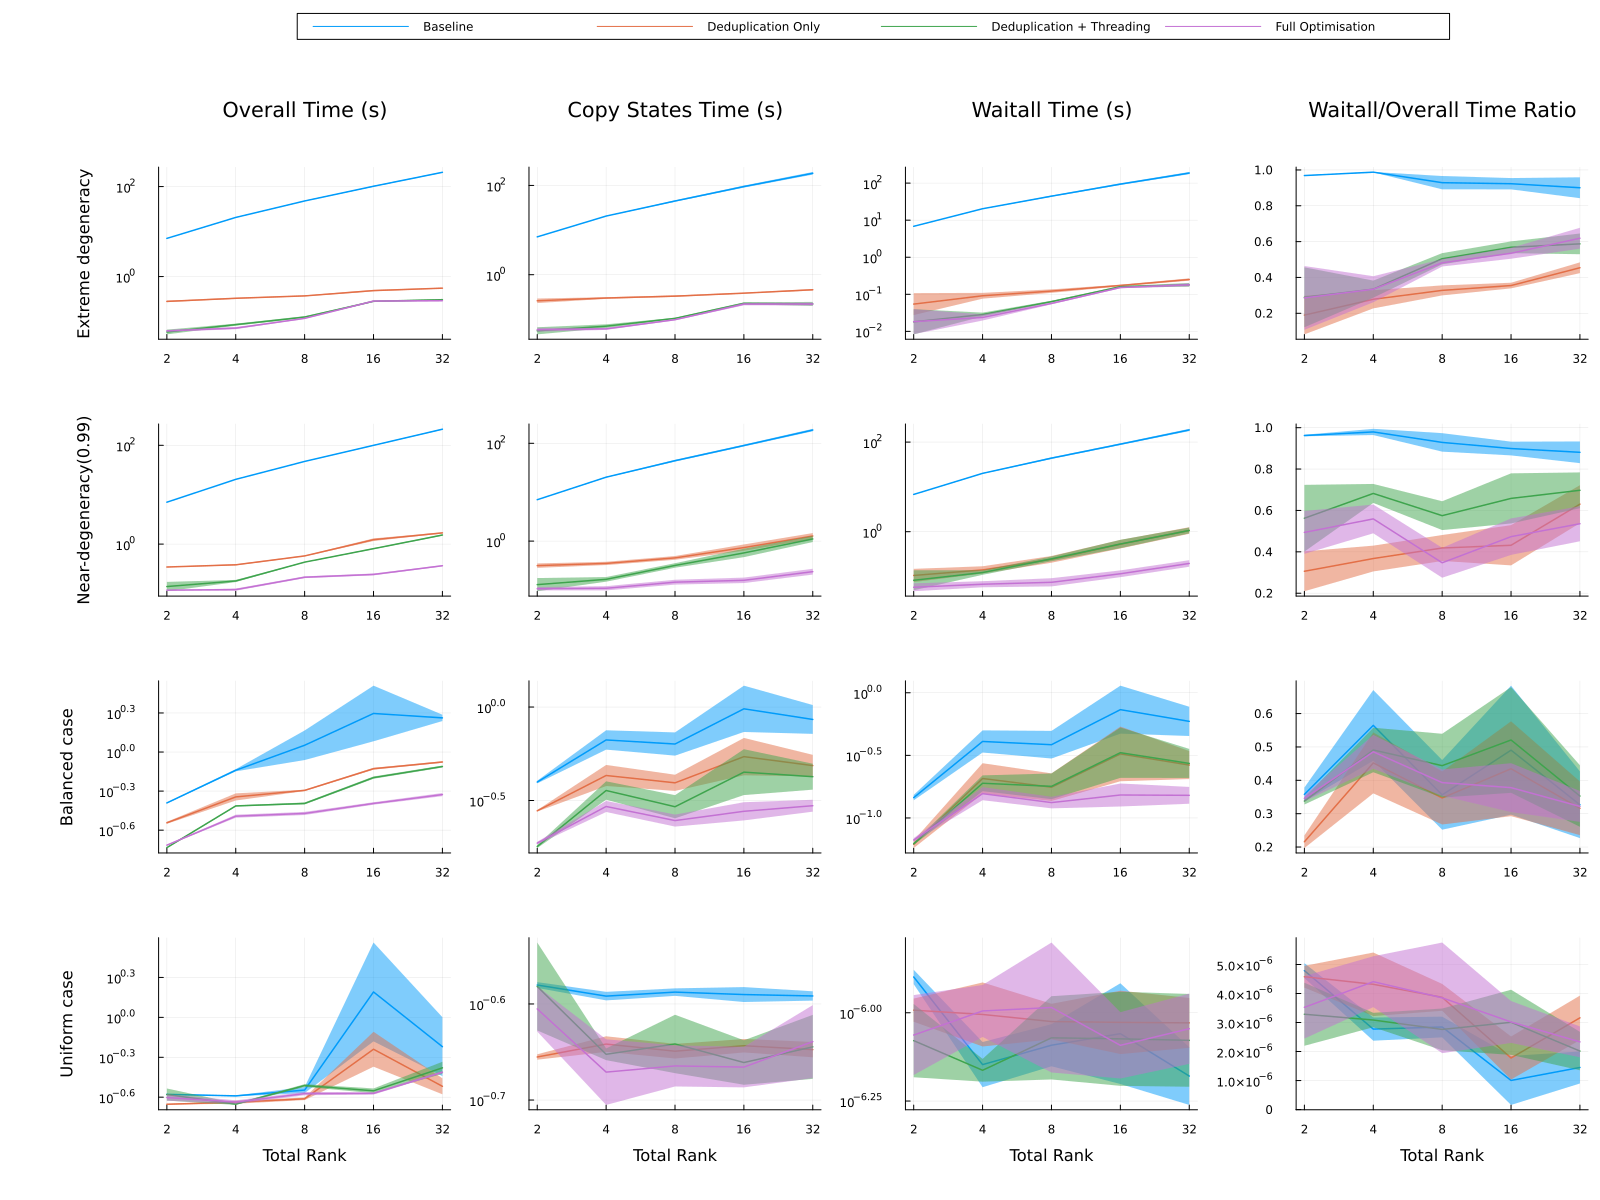

In [86]:
root_dir = "test/output"
dfs = [df_from_h5(root_dir, category) for category in [
    "original",
    "only_dedup",
    "dedup_threading",
    "dedup_threading_optimize_resampling"
]]

union_df = vcat(dfs...)
union_df = widen_ops(union_df)
union_df = stats(union_df)
render_stats(union_df)